In [18]:
import numpy as np
import pandas as pd
import kagglehub
from kagglehub import KaggleDatasetAdapter
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [19]:
class K_means:
    def __init__(self, k, init, max_itrns=100, tolerance=1e-4, random_state=None):
        self.k = k
        self.init = init
        self.max_itrns = max_itrns
        self.tolerance = tolerance
        self.random_state = random_state
        self.centroids = None
        self.labels = None
        self.inertia_history = []
    
    def _init_random(self, x):
        num_of_samples = x.shape[0] # rows
        indices = np.random.choice(num_of_samples, size=self.k, replace=False)
        return  x[indices]
    
    def _init_Kpp(self, x):
        num_of_samples = x.shape[0] # rows
        index = np.random.randint(num_of_samples) # only one sample
        centroids = []
        centroids.append(x[index])

        for _ in range(1, self.k):
            dists_sq = np.min(
                    [np.sum((x - c) ** 2, axis=1) for c in centroids],
                    axis=0
                ) # for each point in x:
                # compute distance to every centroid
                # keep the smallest one
            probs = dists_sq / np.sum(dists_sq)
            index = np.random.choice(num_of_samples, p=probs) 
            centroids.append(x[index])

        return np.array(centroids)

    def assign_clusters(self, x):
        distances = np.linalg.norm(x[:, None] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

    def compute_centroids(self, x):
        new_centroids = np.array([
            x[self.labels == i].mean(axis=0)
            if i in self.labels
            else self.centroids[i]  # handle empty cluster
            for i in range(self.k)
        ])
        return new_centroids

    def compute_inertia(self, x):
        return np.sum((x - self.centroids[self.labels]) ** 2)
    
    def fit(self, x):
        if self.random_state is not None:
            np.random.seed(self.random_state)

        if self.init == "random":
            self.centroids = self._init_random(x)
        elif self.init == "kmeans++":
            self.centroids = self._init_Kpp(x)
        else:
            raise ValueError("init must be 'random' or 'kmeans++'")

        for _ in range(self.max_itrns):
            self.labels = self.assign_clusters(x)
            inertia = self.compute_inertia(x)
            self.inertia_history.append(inertia)

            new_centroids = self.compute_centroids(x)

            # tolerance-based convergence
            shift = np.linalg.norm(self.centroids - new_centroids)
            if shift < self.tolerance:
                break

            self.centroids = new_centroids
        return self

    def predict(self, x):
        return self.assign_clusters(x)

In [20]:
df = kagglehub.dataset_load(KaggleDatasetAdapter.PANDAS,
                            "uciml/breast-cancer-wisconsin-data",
                            "data.csv"
    )

print(df.shape)

(569, 33)


In [21]:
y = df["diagnosis"].map({"M": 1, "B": 0}).values

# drop non-feature columns
x = df.drop(columns=["id", "diagnosis", "Unnamed: 32"], errors="ignore").values

# standardize features
scaler = StandardScaler()
x = scaler.fit_transform(x)

print(x.shape)  

(569, 30)


In [22]:
k = 2

kmeans_rand = K_means(k=k, init="random", random_state=42)
kmeans_rand.fit(x)

kmeans_pp = K_means(k=k, init="kmeans++", random_state=42)
kmeans_pp.fit(x)

print("Random inertia:", kmeans_rand.inertia_history)
print("KMeans++ inertia:", kmeans_pp.inertia_history)

Random inertia: [np.float64(14858.8699757902), np.float64(12314.304570602611), np.float64(11757.962300562953), np.float64(11629.926443563687), np.float64(11606.166488599923), np.float64(11600.60070303026), np.float64(11597.156850055539), np.float64(11595.859480779383), np.float64(11595.683312822135)]
KMeans++ inertia: [np.float64(16420.447280984325), np.float64(11599.968580449826), np.float64(11595.696480334787), np.float64(11595.526607115786)]


## Experiment 1
### 1.a Elbow method


In [23]:
ks_elbow = range(1, 10)
inertias = []

for k in ks_elbow:
    kmeans = K_means(k=k, init="kmeans++", random_state=42)
    kmeans.fit(x)
    inertias.append(kmeans.inertia_history[-1])

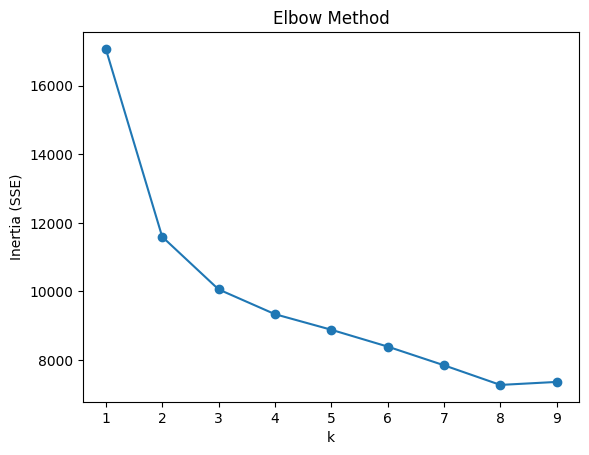

In [24]:
plt.plot(ks_elbow, inertias, marker='o')
plt.xlabel("k")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow Method")
plt.show()

### 1b. Silhouette analysis

In [25]:
def silhouette_score_scratch(X, labels):
    n = x.shape[0]
    unique_labels = np.unique(y)
    k = len(unique_labels)

    # Precompute full distance matrix
    dist_matrix = np.linalg.norm(x[:, None] - x[None, :], axis=2)

    silhouettes = []

    for i in range(n):
        same_cluster = y == y[i]
        other_clusters = unique_labels[unique_labels != y[i]]

        # a(i): mean intra-cluster distance
        if np.sum(same_cluster) > 1:
            a = np.mean(dist_matrix[i, same_cluster & (np.arange(n) != i)])
        else:
            a = 0.0

        # b(i): min mean distance to other clusters
        b = np.inf
        for c in other_clusters:
            mask = y == c
            b = min(b, np.mean(dist_matrix[i, mask]))

        s = (b - a) / max(a, b) if max(a, b) > 0 else 0
        silhouettes.append(s)
    return np.mean(silhouettes)

In [26]:
sil_scores = []
ks_silhouette = range(2, 10)

for k in ks_silhouette:
    km = K_means(k=k, init="kmeans++", random_state=42)
    km.fit(x)
    score = silhouette_score_scratch(x, km.labels)
    sil_scores.append(score)

print(sil_scores)

[np.float64(0.29406527304986996), np.float64(0.29406527304986996), np.float64(0.29406527304986996), np.float64(0.29406527304986996), np.float64(0.29406527304986996), np.float64(0.29406527304986996), np.float64(0.29406527304986996), np.float64(0.29406527304986996)]


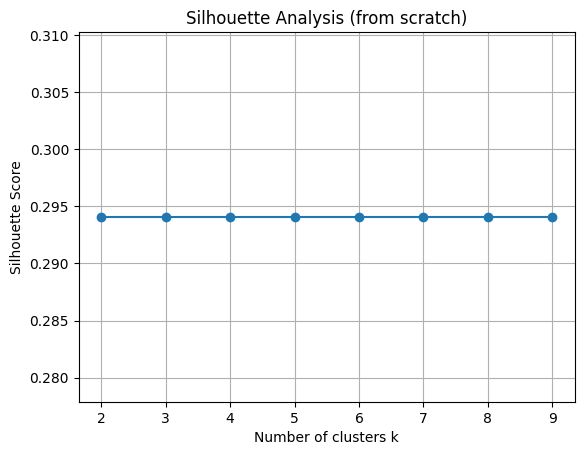

In [27]:
plt.figure()
plt.plot(ks_silhouette, sil_scores, marker='o')
plt.xlabel("Number of clusters k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis (from scratch)")
plt.grid(True)
plt.show()

### 1c. Statistic gap


In [28]:
def gap_statistic_scratch(x, k, B=10):
    n, d = x.shape
    
    # Fit on real data
    km = K_means(k=k, init="kmeans++", random_state=42)
    km.fit(x)
    Wk = km.inertia_history[-1]

    # Bounds for uniform sampling
    mins = x.min(axis=0)
    maxs = x.max(axis=0)

    Wk_refs = []

    for _ in range(B):
        X_ref = np.random.uniform(mins, maxs, size=(n, d))
        km_ref = K_means(k=k, init="kmeans++")
        km_ref.fit(X_ref)
        Wk_refs.append(km_ref.inertia_history[-1])

    Wk_refs = np.array(Wk_refs)
    gap = np.mean(np.log(Wk_refs)) - np.log(Wk)

    return gap


In [29]:
gaps = []
ks_gap = range(1, 10)

for k in ks_gap:
    gap = gap_statistic_scratch(x, k, B=5)  # B=5 for speed
    gaps.append(gap)

print(gaps)


[np.float64(1.6389167327800145), np.float64(1.9536537681967943), np.float64(2.058536408688715), np.float64(2.0976287642356226), np.float64(2.1290630951463445), np.float64(2.172024703744375), np.float64(2.219295093894617), np.float64(2.2783377144869874), np.float64(2.2522920254074528)]


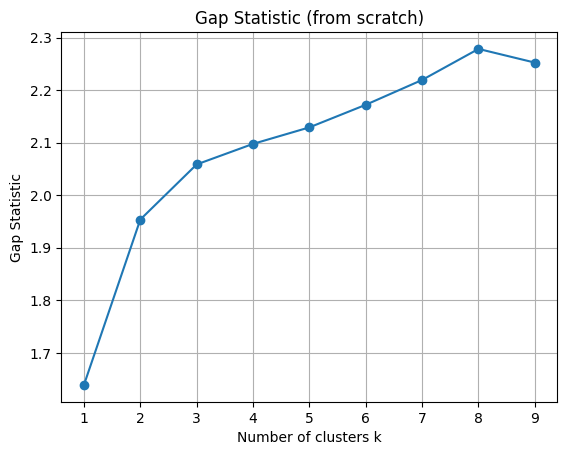

In [30]:
plt.figure()
plt.plot(ks_gap, gaps, marker='o')
plt.xlabel("Number of clusters k")
plt.ylabel("Gap Statistic")
plt.title("Gap Statistic (from scratch)")
plt.grid(True)
plt.show()

### 2. K++ vs random


In [31]:
km_pp = K_means(k=k, init="kmeans++", random_state=42)
km_pp.fit(x)

km_rand = K_means(k=k, init="random", random_state=42)
km_rand.fit(x)

print("K-Means++: iterations =", len(km_pp.inertia_history))
print("Random Init: iterations =", len(km_rand.inertia_history))
print("Final Inertia K-Means++:", km_pp.inertia_history[-1])
print("Final Inertia Random Init:", km_rand.inertia_history[-1])

K-Means++: iterations = 25
Random Init: iterations = 28
Final Inertia K-Means++: 7364.373373144285
Final Inertia Random Init: 7214.342066149598


### 3. Reporting convergance


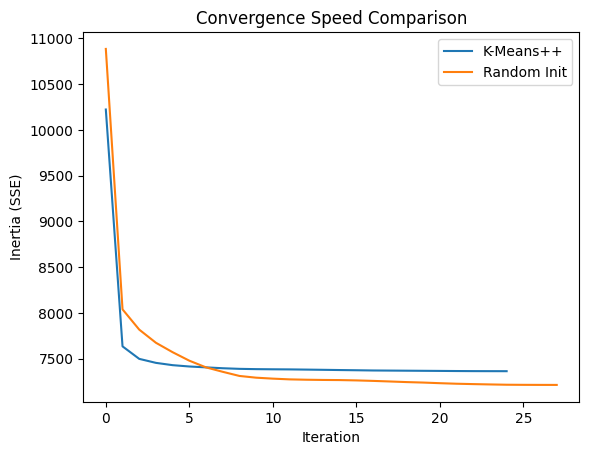

In [32]:
plt.plot(km_pp.inertia_history, label="K-Means++")
plt.plot(km_rand.inertia_history, label="Random Init")
plt.xlabel("Iteration")
plt.ylabel("Inertia (SSE)")
plt.title("Convergence Speed Comparison")
plt.legend()
plt.show()